# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

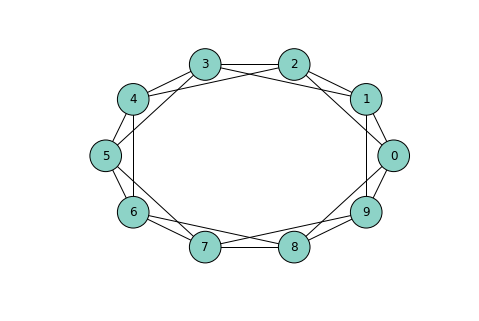

In [7]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)
plt.savefig('chap03-1.pdf')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=2` or `k=5`.

Answer: (Integer division is displeased with odd numbers.)

## WS graph

To make a WS, you start with a ring lattice and then rewire.

In [8]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [9]:
from numpy.random import choice

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            choices = nodes - {u} - set(G[u]) # all nodes, less the node itself and its current neighbors.
            new_v = choice(tuple(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

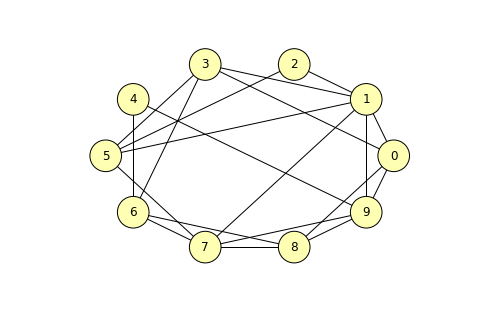

In [10]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [11]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

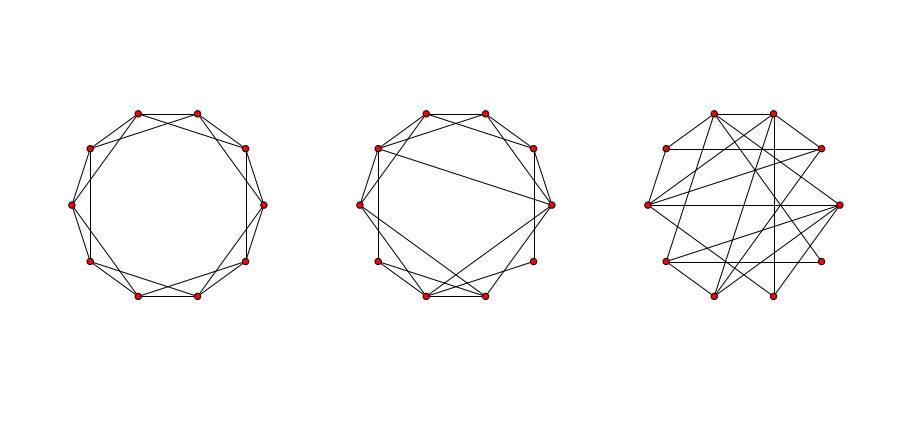

In [12]:
n = 10
k = 4
ns = 40

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
plt.savefig('chap03-2.pdf')

**Exercise:** What is the order of growth of `rewire`?

For k, the size of neighborhoods, and n, the number of nodes, rewire conducts up to ((k/2)\*n) operations of O(n), set subtraction. This yields O(kn^2) as the order of growth.

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [13]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / total

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [14]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cc = np.mean([node_clustering(G, node) for node in G])
    return cc

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [15]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [16]:
clustering_coefficient(lattice)

0.5

Correct.

**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.

In [17]:
def node_clustering_list_comprehension(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    looks for the portion of possible neighbor-connections which are filled.
    there are k*(k-1)/2 possible connections between neighbors, etc.
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    existing_pairs = [(v,w) for v, w in all_pairs(neighbors) if G.has_edge(v,w)]
    # technically a list comprehension, but i can see no reason to do it this way
    # besides for list comprehensions' sake. will try to think of a more useful
    # list to use.
    return len(existing_pairs) / total

**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

n nodes, m edges, k neighborhood size (so, m = (k\*n/2))

Performs node_clustering n times, then takes the mean. np.mean is probably linear, so that won't factor into the order of growth here.

node_clustering performs (k)(k-1)/2 constant-time checks.  So, we perform (nk^2 - k)/2 + n constant checks. The order of growth is thus O(nk^2).


## Path length

The following function computes path lengths between all pairs of nodes

In [18]:
def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length_map[u][v] for u, v in all_pairs(G)]
    return lengths

The characteristic path length is the mean path length for all pairs.

In [19]:
def characteristic_path_length(G):
    return np.mean(path_lengths(G))

On a complete graph, the average path length should be 1

In [20]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [21]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [44]:
print(characteristic_path_length(make_ring_lattice(10,4)))

1.66666666667


## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [23]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes about a second on my computer:

In [24]:
%time run_one_graph(1000, 10, 0.01)

8.28896696697 0.644773015873
CPU times: user 1.05 s, sys: 72 ms, total: 1.12 s
Wall time: 960 ms


(8.2889669669669672, 0.64477301587301272)

Now we'll run it with a range of values for `p`.

In [25]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [26]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

Here are the raw results

In [27]:
res = run_experiment(ps)

0.0001
40.5586446446 0.666423232323
50.4504504505 0.666666666667
50.4504504505 0.666666666667
42.5435135135 0.666423232323
50.4504504505 0.666666666667
47.2872632633 0.666278787879
50.4504504505 0.666666666667
49.82804004 0.666351010101
40.1102762763 0.666134343434
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
39.6356356356 0.665963131313
37.9293013013 0.666107575758
50.4211191191 0.666384848485
50.4504504505 0.666666666667
39.8014494494 0.666351010101
50.4504504505 0.666666666667
50.4504504505 0.666666666667
0.000316227766017
38.53002002 0.666423232323
32.7859219219 0.665286363636
36.9473093093 0.665890909091
26.7532292292 0.665503030303
36.4936216216 0.665746464646
34.7754554555 0.665746464646
41.8450750751 0.666278787879
45.4095435435 0.665963131313
33.5735475475 0.665963131313
38.6045785786 0.666423232323
32.2358298298 0.665042929293
33.3399079079 0.665746464646
38.742980981 0.666278787879
45.4724864865 0.6661343

Now we have to extract them in a form we can plot

In [28]:
L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
print(L)
print(C)

[47.153509909909914, 38.388214414414421, 27.601071771771768, 16.023970970970975, 8.8731543543543534, 5.9947393393393389, 4.436626826826827, 3.5785572572572568, 3.2671586586586585]
[0.66648752525252231, 0.66589131313131, 0.66476159090908771, 0.66104016594516257, 0.64724840548340234, 0.6079336960261944, 0.49004759712509749, 0.21974964924781118, 0.0093260291789393976]


And normalize them so they both start at 1.0

In [29]:
L = np.array(L) / L[0]
C = np.array(C) / C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

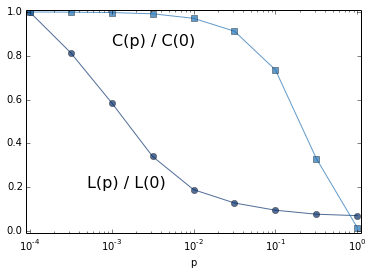

In [30]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])
plt.savefig('chap03-3.pdf')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [31]:
lattice = make_ring_lattice(10, 4)

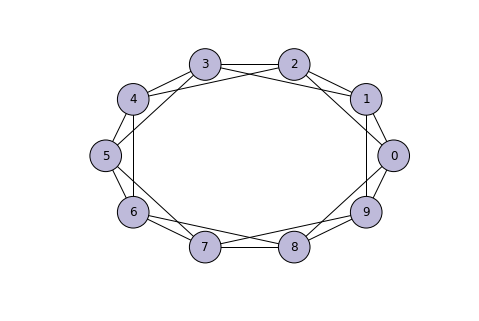

In [32]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [33]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [34]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [35]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) 
            neighbors -= seen
            queue.extend(neighbors)
    return seen

It works, too.

In [36]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [37]:
def shortest_path_dijkstra(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [38]:
lattice = make_ring_lattice(10, 4)

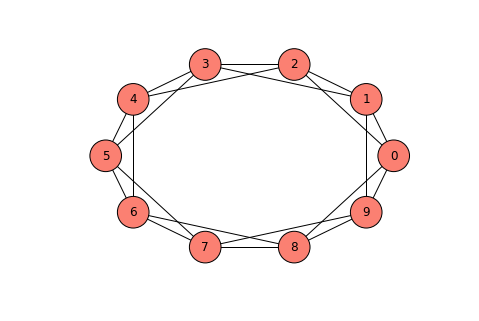

In [39]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [40]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [41]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [42]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [62]:
a = shortest_path_dijkstra(make_ring_lattice(1000,10),0)
#indicates that the maximum distance is 100, and is the 500th node.

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [45]:
def make_regular_graph(n,k):
    """
    n nodes, each of degree k.
    """
    if k >= n:
        raise ValueError("Cannot have greater degree than (nodes-1)")
    if k%2 == 0:
        G = make_ring_lattice(n,k)
        return G
    else: # k is odd
        if n%2 != 0:
            raise ValueError("Cannot create regular graph of odd degree with odd node count")
            # This would require half-edges, as the total number of edges in a regular graph is (n*k)/2.
        G = make_ring_lattice(n,k-1)
        nodes = G.nodes()
        new_pairs = [(nodes[i], nodes[(i+(n/2))%n]) for i in range(n/2)] 
        # Connects the nodes on opposite "sides" of the ring.
        G.add_edges_from(new_pairs)
        return G

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [46]:
def plain_bfs(G, source):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [47]:
lattice = make_ring_lattice(10, 4)

%timeit len(reachable_nodes_bfs(lattice,0))

The slowest run took 11.10 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.56 µs per loop


In [48]:
%timeit len(plain_bfs(lattice,0))

The slowest run took 4.91 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 5.29 µs per loop


In [53]:
# For reference:
def shortest_path_dijkstra(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

In [54]:
%timeit shortest_path_dijkstra(lattice,0)

The slowest run took 8.67 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.46 µs per loop


In [55]:
def alternate_shortest_path_dijkstra(G, start):
    """
    Finds the shortest paths from start to other nodes.
    Tries to have less overhead from adding/removing queue elements.
    """
    dist = {start: 0}
    levelcount = 0
    seen = set()
    nextlevel = {start} # this just makes it as a set right?
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
                dist[v] = levelcount
        levelcount += 1
    return dist

# print(shortest_path_dijkstra(lattice,0))
# print("\n=======================\n")
# print(alternate_shortest_path_dijkstra(lattice,0))

In [56]:
%timeit alternate_shortest_path_dijkstra(lattice,0)

100000 loops, best of 3: 5.88 µs per loop


**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [60]:
def bfs(top_node, visit):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [top_node]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visit(curr_node)            # Visit the node
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in curr_node.children
                     if c not in visited and c not in queue)

In [61]:
# Pretty sure the assignment was 3.1, 3.2, 3.5. So, I'm disregarding this exercise and the next one.

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [58]:
# See above comment.

**Exercise:** A natural question about the Watts and Strogatz paper is
whether the small world phenomenon is specific to their generative model or
whether other similar models yield the same qualitative result (high clustering
and low path lengths).

To answer this question, choose a variation of the Watts and Strogatz model
and repeat the experiment. There are two kinds of variation you might consider:

Instead of starting with a regular graph, start with another graph with
high clustering. For example, you could put nodes at random locations
in a 2-D space and connect each node to its nearest k neighbors.

Experiment with different kinds of rewiring.

If a range of similar models yield similar behavior, we say that the results of
the paper are robust

Consider a variant on the Watts-Strogatz model where, rather than randomly rewiring, specific "bridges" every [second, third, fifth, or other] node are created. In other words, a variant where the rewiring doesn't travel "far" -- say, one which always moves edges to the nodes (k/2)+1 away (a *small* jump), or to the node on the opposite side of the ring (a large jump).

In [63]:
from numpy.random import choice

def make_variant_ws(n,k,d,s):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    d: fixed "clockwise" distance for each bridge/jump; max of n/2.
    s: skip - how often to have a bridge. 1 for every node, 2 for every other node, etc.
    """
    vws = make_ring_lattice(n, k)
    variant_rewire(vws, k, d, s)
    return vws

def variant_rewire(G, k, d, s):
    "Rewires every s-th node to be attached to a node d 'clockwise'"
    nodes = G.nodes()
    nodecount = len(G) # could alternatively pass in the original n.
    for i in range(nodecount):
        if i%s == 0:
            G.remove_edge(nodes[i], nodes[(i+(k/2))%nodecount])
            G.add_edge(nodes[i], nodes[(i+d)%nodecount])
    return G
    
# For analysis, instead of copy-pasting a bunch of other code,
# I can just copy-paste this in for the earlier make_ws and rewire functions as-needed.

Analysis of this variation - with "rules" of rewiring, so to speak - yields fairly robust results. The path-shortening of smaller jumps is, as we might expect, of a slightly lower magnitude; for the longest-possible bridge (to the opposite side of the ring), certain paths will be much shorter and others will have no significant change.